In [2]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import(
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import(
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.ensemble import(
    RandomForestClassifier
)

from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import(
    permutation_importance
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [4]:
df_raw = pd.read_csv('../data/Maternal Health Risk Data Set.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [5]:
df_raw.sample(10, random_state=2025)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
109,32,140,100,7.9,98.0,78,high risk
185,55,100,65,6.1,98.0,66,low risk
402,35,100,70,7.8,98.0,60,low risk
800,32,120,80,6.8,98.0,70,mid risk
684,32,140,100,6.9,98.0,78,high risk
555,50,130,100,16.0,98.0,75,mid risk
34,21,75,50,6.1,98.0,70,low risk
689,40,160,100,19.0,98.0,77,high risk
172,20,100,90,7.1,98.0,88,low risk
528,15,78,49,7.5,98.0,77,low risk


### **2. Data preprocessing**


In [6]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['risklevel']= df_baking['risklevel'].astype('category') 
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          1014 non-null   int64   
 1   systolicbp   1014 non-null   int64   
 2   diastolicbp  1014 non-null   int64   
 3   bs           1014 non-null   float64 
 4   bodytemp     1014 non-null   float64 
 5   heartrate    1014 non-null   int64   
 6   risklevel    1014 non-null   category
dtypes: category(1), float64(2), int64(4)
memory usage: 48.8 KB


### **3. Exploratory Data Analysis**



In [12]:
df_train = df.copy()
df_test = df.copy()
df_train,df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=2025,
    stratify=df_train['risklevel']
)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 661 to 601
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          811 non-null    int64   
 1   systolicbp   811 non-null    int64   
 2   diastolicbp  811 non-null    int64   
 3   bs           811 non-null    float64 
 4   bodytemp     811 non-null    float64 
 5   heartrate    811 non-null    int64   
 6   risklevel    811 non-null    category
dtypes: category(1), float64(2), int64(4)
memory usage: 45.3 KB


In [13]:
display(df_train.describe().T)
display(df_train.describe(include="category").T)

,count,mean,std,min,25%,50%,75%,max
age,811.0,29.905055,13.653367,10.0,19.0,25.0,38.5,66.0
systolicbp,811.0,113.172626,18.392156,70.0,99.5,120.0,120.0,160.0
diastolicbp,811.0,76.499383,13.802610,49.0,65.0,80.0,90.0,100.0
bs,811.0,8.766634,3.304571,6.0,6.9,7.5,8.0,19.0
bodytemp,811.0,98.646609,1.360192,98.0,98.0,98.0,98.0,103.0
heartrate,811.0,74.129470,8.248113,7.0,70.0,76.0,80.0,90.0


,count,unique,top,freq
risklevel,811,3,low risk,325


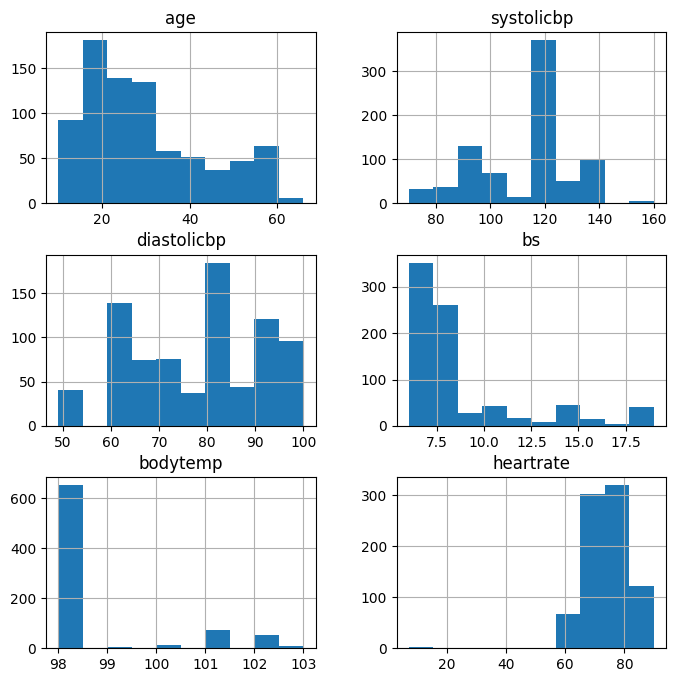

In [23]:
df_train.hist(figsize=(8,8))
plt.show()

/tmp/ipykernel_94471/1834016819.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='risklevel', palette='Set2')


<Axes: xlabel='risklevel', ylabel='count'>

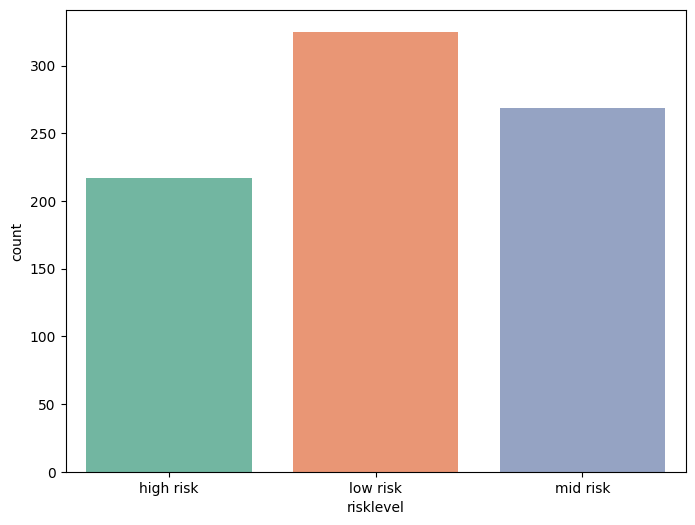

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='risklevel', palette='Set2')

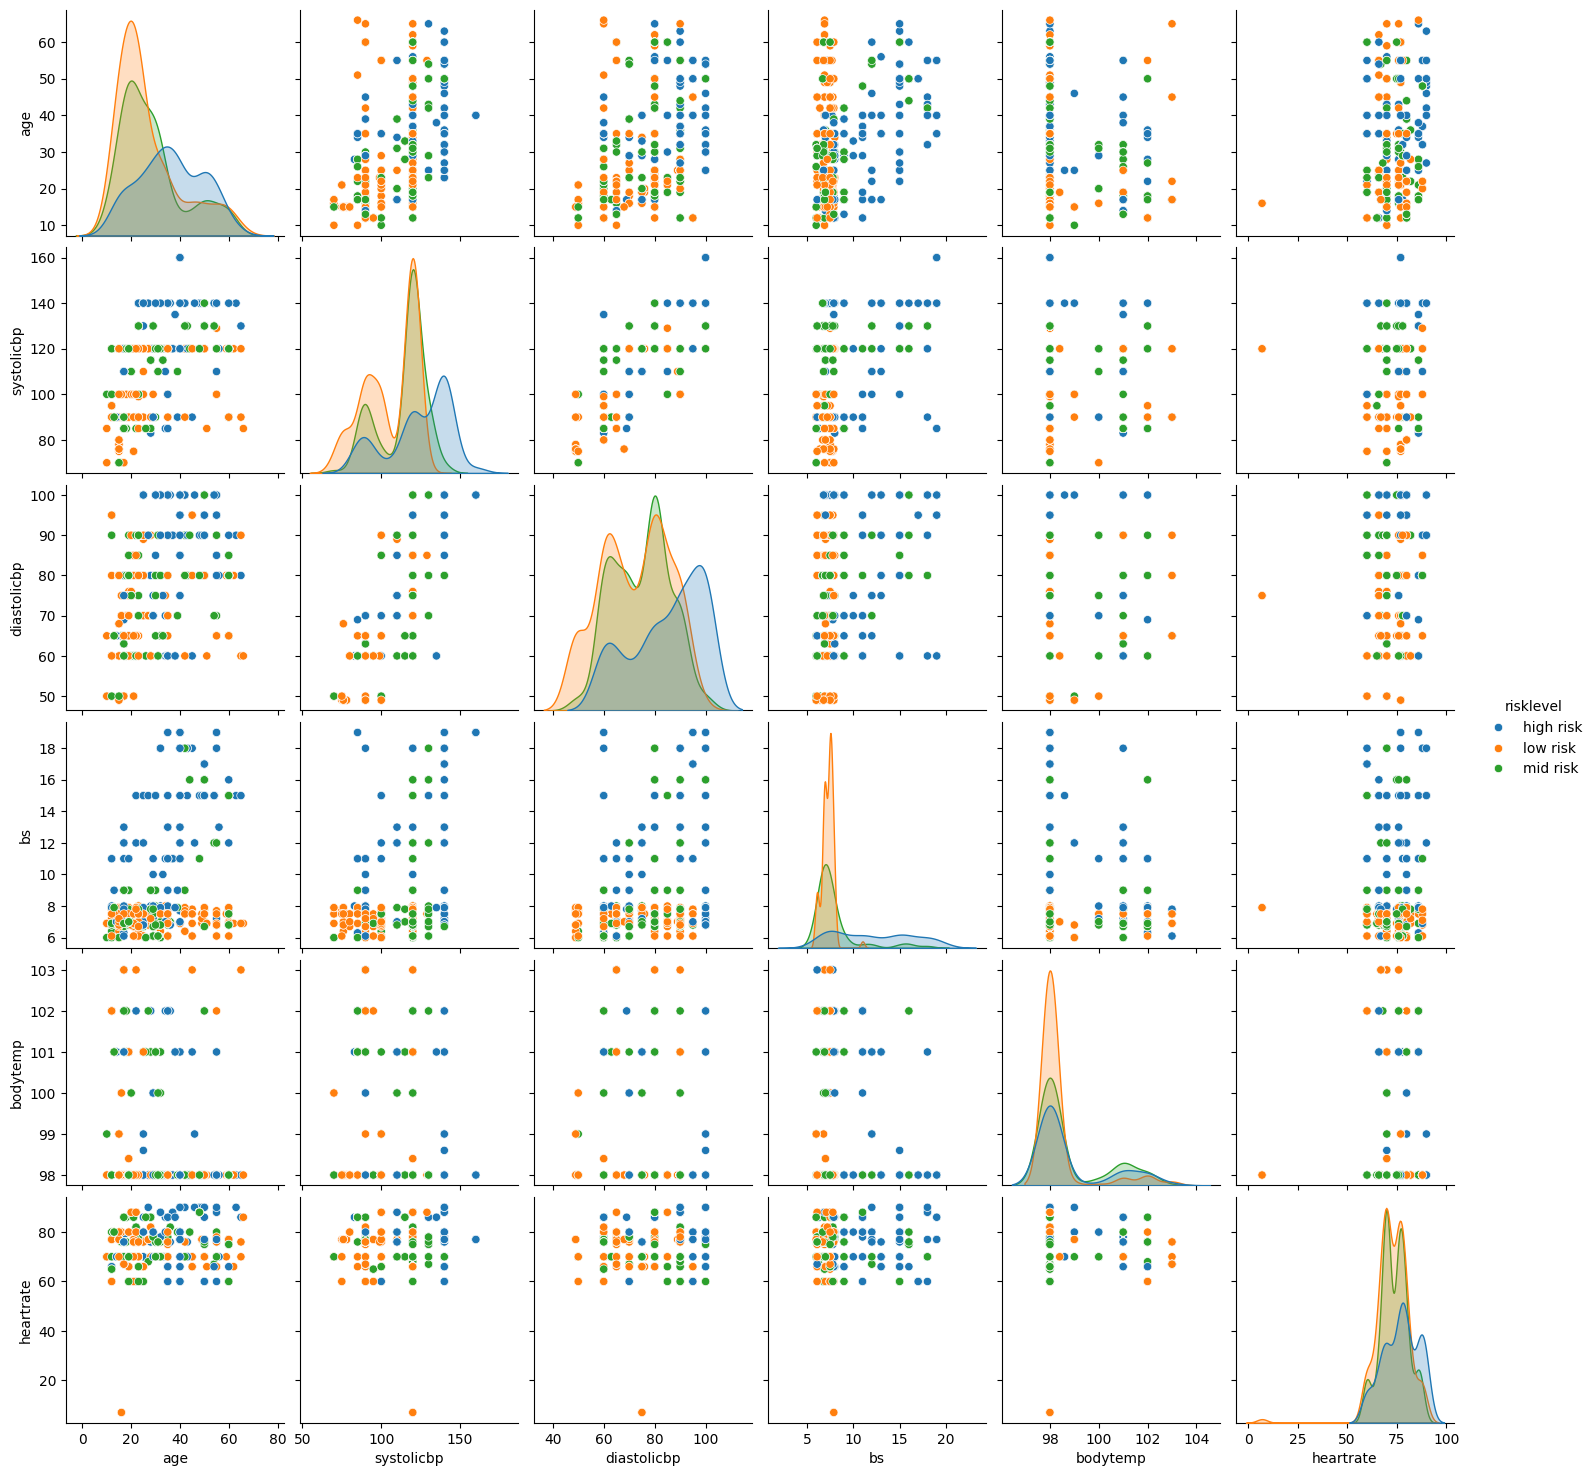

In [15]:
sns.pairplot(df_train,hue = "risklevel")
plt.show()

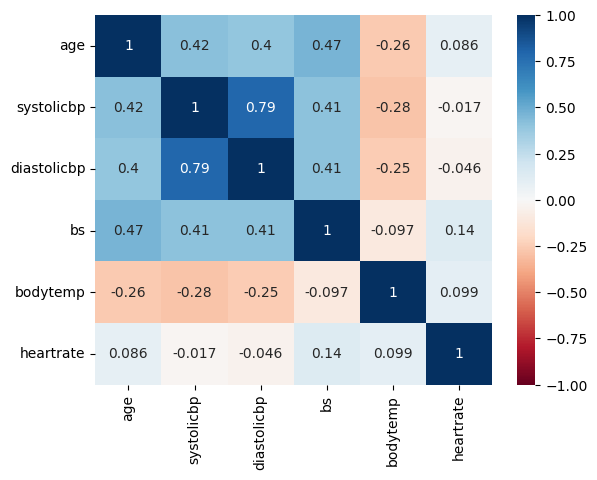

In [16]:
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning


In [17]:
X_train = df_train[['age', 'systolicbp', 'diastolicbp', 'bs', 'bodytemp', 'heartrate']].copy()
y_train = df_train['risklevel'].copy()

X_val = df_val[['age', 'systolicbp', 'diastolicbp', 'bs', 'bodytemp', 'heartrate']].copy()
y_val = df_val['risklevel'].copy()

X_test = df_test[['age', 'systolicbp', 'diastolicbp', 'bs', 'bodytemp', 'heartrate']].copy()
y_test = df_test['risklevel'].copy()


In [18]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val) 
y_test_enc = label_encoder.transform(y_test) 

In [26]:
clf_rforest_p = Pipeline([
    ("powertransform", PowerTransformer()),
    ("rforest",RandomForestClassifier(random_state=2025,class_weight="balanced"))
])
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        "rforest__max_depth":[3,5,7,9],
        "rforest__n_estimators":[20,30,50,100]
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

In [27]:
clf_rforest_cv.fit(X_train,y_train_enc)
clf_rforest_cv.best_params_


{'rforest__max_depth': 9, 'rforest__n_estimators': 50}

accuracy: 0.86
f1_score (macro): 0.86
              precision    recall  f1-score   support

   high risk       0.93      0.96      0.95        55
    low risk       0.83      0.90      0.86        81
    mid risk       0.83      0.72      0.77        67

    accuracy                           0.86       203
   macro avg       0.86      0.86      0.86       203
weighted avg       0.86      0.86      0.85       203



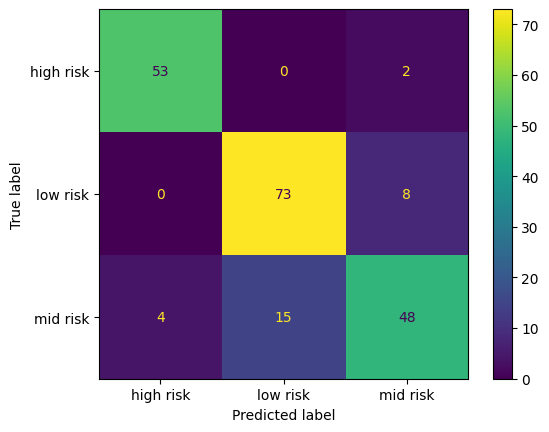

In [29]:
y_hat_val = clf_rforest_cv.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc,y_hat_val):.2f}')
print(f'f1_score (macro): {f1_score(y_val_enc, y_hat_val, average="macro"):.2f}')  # Change made here
print(classification_report(y_val_enc,y_hat_val,target_names= label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels= label_encoder.classes_)
plt.show()



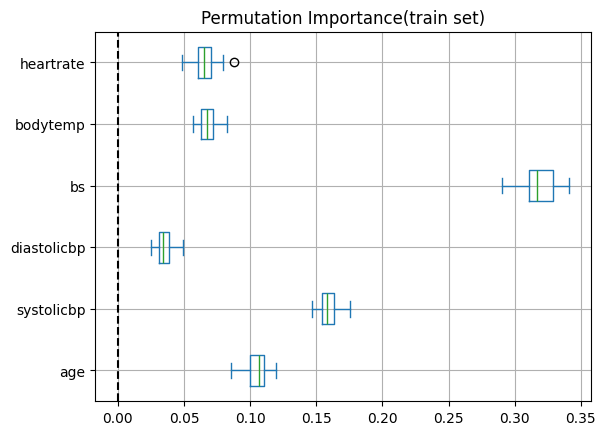

In [31]:
importance = permutation_importance(clf_rforest_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

In [33]:
y_hat_test = clf_rforest_cv.predict(X_test)

print(f'accuracy: {accuracy_score(y_test_enc, y_hat_test):.2f}')
print(f'f1_score (macro): {f1_score(y_test_enc, y_hat_test, average="macro"):.2f}')


accuracy: 0.87
f1_score (macro): 0.88
